In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# Base.prepare(autoload_with=engine)

/var/folders/fv/ltttqpzd0bn28sqs0_gjbh300000gn/T/ipykernel_15327/191687242.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
#another way of getting the same results but using inspect 
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Get a list of column names and types for the station class
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Get a list of column names and types for the measurement class
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

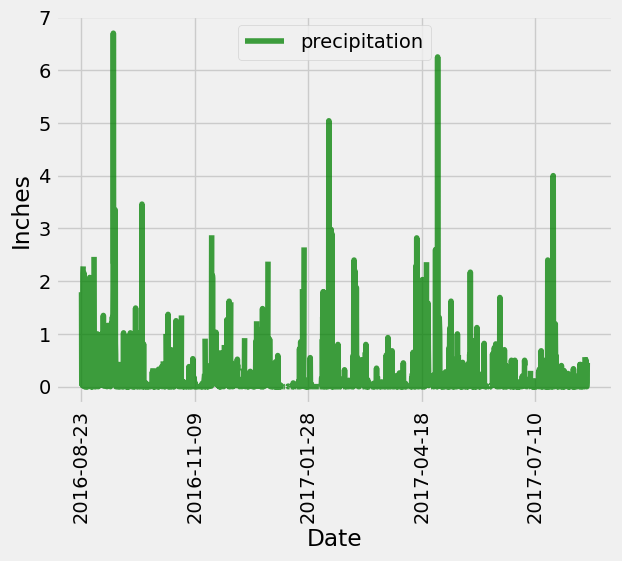

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days= 365 )

# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date, measurement.prcp]
precipitation_scores = session.query(*sel).filter(measurement.date >= one_year_ago ).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_scores, columns= ['date', 'precipitation'])

# Sort the dataframe by date
sorted_by_date = df.sort_values('date', ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data

sorted_by_date.plot(x='date', y='precipitation', rot=90, color='green', alpha=0.75)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(["precipitation"], loc='upper center')
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station).filter(station.name.isnot(None)).count()
#scalar for unique value
total_stations = session.query(func.count(station.id)).first()
total_stations

(9,)

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station,func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
filter(measurement.station == 'USC00519281').first()
temperature_stats

(54.0, 85.0, 71.66378066378067)

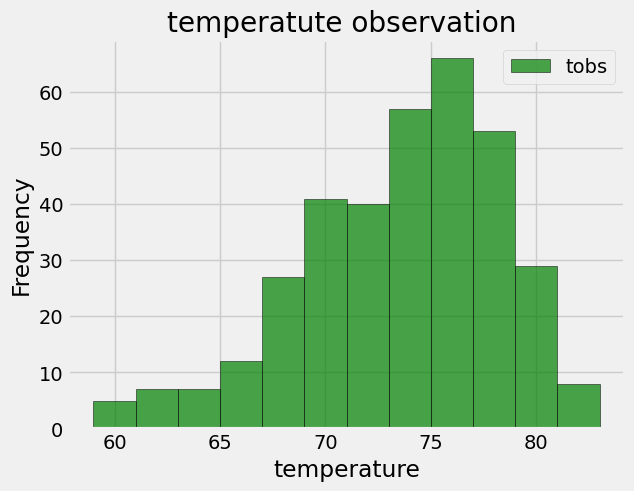

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observation = session.query(measurement.tobs, measurement.date).filter(measurement.station == 'USC00519281').\
filter(measurement.date >= one_year_ago).all()
temp_obs_df = pd.DataFrame(temp_observation, columns=['tobs', 'date'])

#histogram
plt.hist(temp_obs_df['tobs'], bins=12, color='green', alpha=0.7, edgecolor='black')  # Customize the number of bins and colors
plt.ylabel('Frequency')
plt.legend(['tobs'], loc='upper right')
plt.xlabel('temperature')
plt.title('temperatute observation ')
plt.show()

# Close Session

In [19]:
# Close Session
session.close()